In [1]:
import getopt
import sys
import gc
import os
sys.path.append('/home/atac2rna/program/atac2rna/Model/butterfly/Butterfly/')
from data_processing import RNA_data_preprocessing, ATAC_data_preprocessing
import scanpy as sc
import anndata as ad

model_type = 'basic'
data = 'ma'
file_path = '/home/atac2rna/data/atac2rna/model_output/22_10_12/split_cluster/test'
number = 4


RNA_data = sc.read_h5ad('/data/cabins/chenshengquan/scglue/Ma-2020-RNA.h5ad')
ATAC_data = sc.read_h5ad('/data/cabins/chenshengquan/scglue/Ma-2020-ATAC.h5ad')


############################################################
# Part 1 data processing
RNA_data = RNA_data_preprocessing(
    RNA_data,
    normalize_total=True,
    log1p=True,
    use_hvg=True,
    n_top_genes=3000,
    save_data=False,
    file_path=file_path,
    logging_path=file_path
    )
ATAC_data = ATAC_data_preprocessing(
    ATAC_data,
    binary_data=True,
    filter_features=True,
    fpeaks=0.005,
    tfidf=True,
    normalize=True,
    save_data=False,
    file_path=file_path,
    logging_path=file_path
)[0]


############################################################
# Part 2 split datasets
from split_datasets import *
id_list = batch_split_dataset(RNA_data, ATAC_data)
train_id, validation_id, test_id = id_list[int(number) - 1]
train_id_r = train_id.copy()
train_id_a = train_id.copy()
validation_id_r = validation_id.copy()
validation_id_a = validation_id.copy()
test_id_r = test_id.copy()
test_id_a = test_id.copy()

############################################################
# Part 3 calculate chrom list

chrom_list = [0 for i in range(20)]
for i in range(len(ATAC_data.var.chrom)):
    temp = ATAC_data.var.chrom[i]
    if temp[3:] == 'X':
        chrom_list[19] += 1
    else:
        chrom_list[int(temp[3:]) - 1] += 1
peaks_idx = [[] for i in range(len(chrom_list))]
for i in range(len(ATAC_data.var.chrom)):
    temp = ATAC_data.var.chrom[i]
    if temp[3:] == 'X':
        peaks_idx[19].append(i)
    else:
        peaks_idx[int(temp[3:]) - 1].append(i)
peaks_idx_temp = []
for i in range(len(peaks_idx)):
    peaks_idx_temp.extend(peaks_idx[i])

ATAC_data.X = ATAC_data.X[:, peaks_idx_temp]
ATAC_data.var = ATAC_data.var.iloc[peaks_idx_temp, :]    


from train_model import Model
import torch
import torch.nn as nn

RNA_input_dim = len([i for i in RNA_data.var['highly_variable'] if i])
ATAC_input_dim = ATAC_data.X.shape[1]

R_kl_div = 1 / RNA_input_dim * 20
A_kl_div = 1 / ATAC_input_dim * 20
kl_div = R_kl_div + A_kl_div

train_id, validation_id, test_id = id_list[int(number) - 1]

############################################################
# Part 4 construct model
model = Model(
    R_encoder_nlayer = 2, 
    A_encoder_nlayer = 2,
    R_decoder_nlayer = 2, 
    A_decoder_nlayer = 2,
    R_encoder_dim_list = [RNA_input_dim, 256, 128],
    A_encoder_dim_list = [ATAC_input_dim, 32 * len(chrom_list), 128],
    R_decoder_dim_list = [128, 256, RNA_input_dim],
    A_decoder_dim_list = [128, 32 * len(chrom_list), ATAC_input_dim],
    R_encoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    A_encoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    R_decoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    A_decoder_act_list = [nn.LeakyReLU(), nn.Sigmoid()],
    translator_embed_dim = 128, 
    translator_input_dim_r = 128,
    translator_input_dim_a = 128,
    translator_embed_act_list = [nn.LeakyReLU(), nn.LeakyReLU(), nn.LeakyReLU()],
    discriminator_nlayer = 1,
    discriminator_dim_list_R = [128],
    discriminator_dim_list_A = [128],
    discriminator_act_list = [nn.Sigmoid()],
    dropout_rate = 0.1,
    R_noise_rate = 0.5,
    A_noise_rate = 0.3,
    chrom_list = chrom_list,
    logging_path = file_path,
    RNA_data = RNA_data,
    ATAC_data = ATAC_data
)

In [2]:
import os
import random
import time
import numpy as np
import scanpy as sc
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from model_component import *
from model_utlis import *
from calculate_cluster import *
from draw_cluster import *
from relation_evaluation import *
from data_processing import *
from logger import *

In [3]:
RNA_data = RNA_data
ATAC_data = ATAC_data
test_id_r = test_id_r
test_id_a = test_id_a
model_path = "/home/atac2rna/data/atac2rna/model_output/22_10_12/batch_train/celltype_amp/"+str(data)+"/"+str(number)
load_model = True
output_path = file_path
test_evaluate = False
test_cluster = True
test_umap = True
output_data = False

if load_model:
    model.RNA_encoder.load_state_dict(torch.load(model_path + '/model/RNA_encoder.pt'))
    model.ATAC_encoder.load_state_dict(torch.load(model_path + '/model/ATAC_encoder.pt'))
    model.RNA_decoder.load_state_dict(torch.load(model_path + '/model/RNA_decoder.pt'))
    model.ATAC_decoder.load_state_dict(torch.load(model_path + '/model/ATAC_decoder.pt'))
    model.translator.load_state_dict(torch.load(model_path + '/model/translator.pt'))

""" load data """
RNA_input_dim = model.RNA_data.shape[1]
ATAC_input_dim = model.ATAC_data.shape[1]

model.R_test_dataset = Single_omics_dataset(model.RNA_data, test_id_r)
model.A_test_dataset = Single_omics_dataset(model.ATAC_data, test_id_a)
model.R_test_dataloader = DataLoader(model.R_test_dataset, batch_size=100, shuffle=False, num_workers=4)
model.A_test_dataloader = DataLoader(model.A_test_dataset, batch_size=100, shuffle=False, num_workers=4)

model.set_eval()

""" record the predicted data """
A2R_predict = []
R2A_predict = []
A2_predict = []
R2_predict = []
with torch.no_grad():
    with tqdm(total = len(model.A_test_dataloader), ncols=150, colour='blue') as pbar:
        pbar.set_description('ATAC to RNA predicting...')
        for idx, batch_samples in enumerate(model.A_test_dataloader):
            if torch.cuda.is_available():
                batch_samples = batch_samples.cuda().to(torch.float32)

            A2 = model.ATAC_encoder(batch_samples)
            A2R, A2A, mu_a, sigma_a = model.translator.test_model(A2, 'ATAC')
            A2R = model.RNA_decoder(A2R)

            A2R_predict.append(A2R.cpu())                       
            A2_predict.append(mu_a.cpu())

            time.sleep(0.01)
            pbar.update(1)

with torch.no_grad():
    with tqdm(total = len(model.R_test_dataloader), ncols=150, colour='blue') as pbar:
        pbar.set_description('RNA to ATAC predicting...')
        for idx, batch_samples in enumerate(model.R_test_dataloader):
            if torch.cuda.is_available():
                batch_samples = batch_samples.cuda().to(torch.float32)

            R2 = model.RNA_encoder(batch_samples)
            R2R, R2A, mu_r, sigma_r = model.translator.test_model(R2, 'RNA')
            R2A = model.ATAC_decoder(R2A)

            R2A_predict.append(R2A.cpu())                       
            R2_predict.append(mu_r.cpu())

            time.sleep(0.01)
            pbar.update(1)

A2R_predict = tensor2adata(A2R_predict)
A2R_predict.obs = RNA_data.obs.iloc[test_id_r, :]
A2R_predict.var = RNA_data.var

R2A_predict = tensor2adata(R2A_predict)
R2A_predict.obs = ATAC_data.obs.iloc[test_id_a, :]
R2A_predict.var = ATAC_data.var

RNA to ATAC predicting...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.72it/s]


# ATAC to RNA prediction

In [4]:
sc.pp.pca(A2R_predict)
sc.pp.neighbors(A2R_predict)
sc.tl.tsne(A2R_predict)
sc.tl.leiden(A2R_predict)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


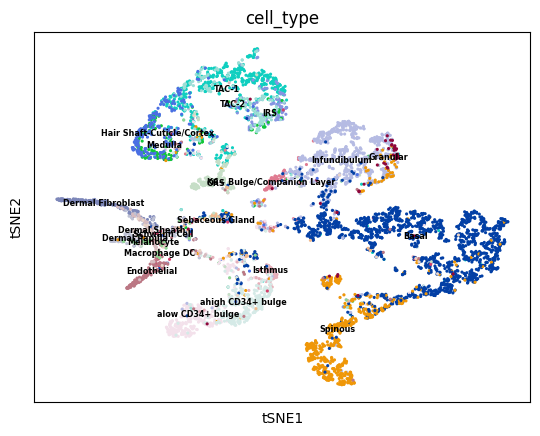

In [5]:
fig_our_tsne_type = sc.pl.tsne(A2R_predict, color='cell_type', legend_loc='on data', title='cell_type', return_fig=True, legend_fontsize='xx-small')

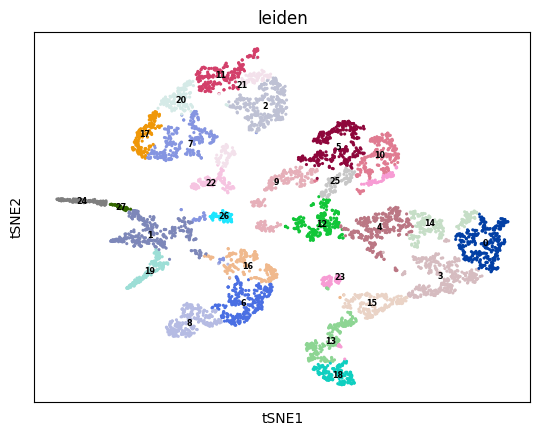

In [6]:
fig = sc.pl.tsne(A2R_predict, color='leiden', legend_loc='on data', title='leiden', return_fig=True, legend_fontsize='xx-small')

In [7]:
import anndata as ad
R_origin_test = ad.AnnData(X=RNA_data.X[test_id_r, :])
R_origin_test.obs = RNA_data.obs.iloc[test_id_r, :]
R_origin_test.var = RNA_data.var

In [8]:
sc.pp.pca(R_origin_test)
sc.pp.neighbors(R_origin_test)
sc.tl.tsne(R_origin_test)
sc.tl.leiden(R_origin_test)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


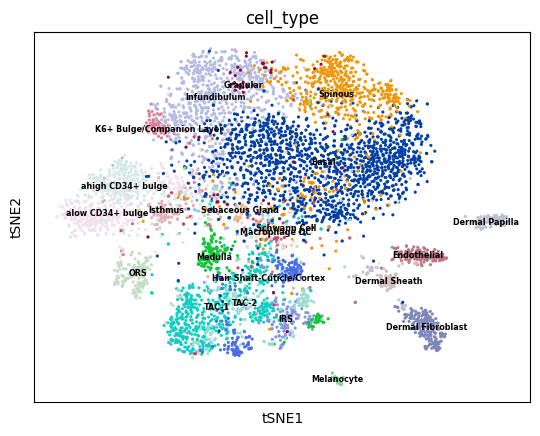

In [9]:
fig =sc.pl.tsne(R_origin_test, color='cell_type', legend_loc='on data', title='cell_type', return_fig=True, legend_fontsize='xx-small')

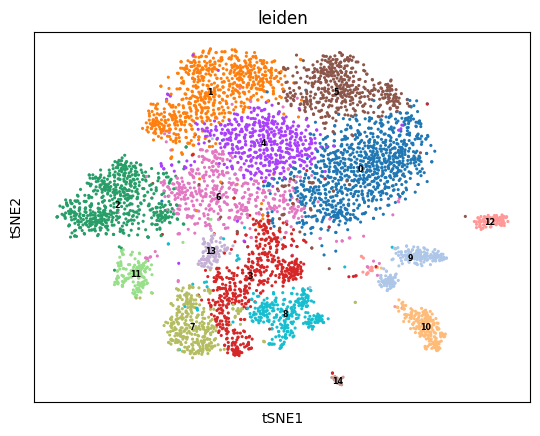

In [10]:
fig = sc.pl.tsne(R_origin_test, color='leiden', legend_loc='on data', title='leiden', return_fig=True, legend_fontsize='xx-small')

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


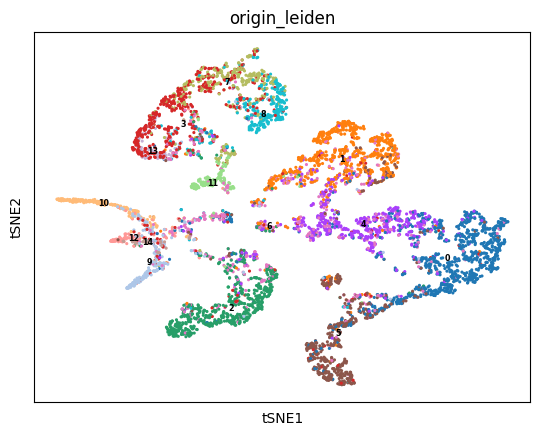

In [11]:
A2R_predict.obs['origin_leiden'] = R_origin_test.obs.leiden
fig_our_tsne_origin_leiden = sc.pl.tsne(A2R_predict, color='origin_leiden', title='origin_leiden', legend_loc='on data', return_fig=True, legend_fontsize='xx-small')

In [13]:
group1 = ['0', '3']
group2 = ['4', '12', '14']
A2R_predict.obs['intergrate_leiden'] = pd.Series(['0' for i in range(len(A2R_predict.obs.leiden))])
for i in range(len(A2R_predict.obs.leiden)):
    if str(A2R_predict.obs.leiden[i]) in group1:
        A2R_predict.obs.intergrate_leiden[i] = '1'
    elif str(A2R_predict.obs.leiden[i]) in group2:
        A2R_predict.obs.intergrate_leiden[i] = '2'
    else:
        A2R_predict.obs.intergrate_leiden[i] = ''

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
group1 = ['0']
group2 = ['4']
R_origin_test.obs['intergrate_leiden'] = pd.Series(['0' for i in range(len(R_origin_test.obs.leiden))])
for i in range(len(R_origin_test.obs.leiden)):
    if str(R_origin_test.obs.leiden[i]) in group1:
        R_origin_test.obs.intergrate_leiden[i] = '1'
    elif str(R_origin_test.obs.leiden[i]) in group2:
        R_origin_test.obs.intergrate_leiden[i] = '2'
    else:
        R_origin_test.obs.intergrate_leiden[i] = '0'

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


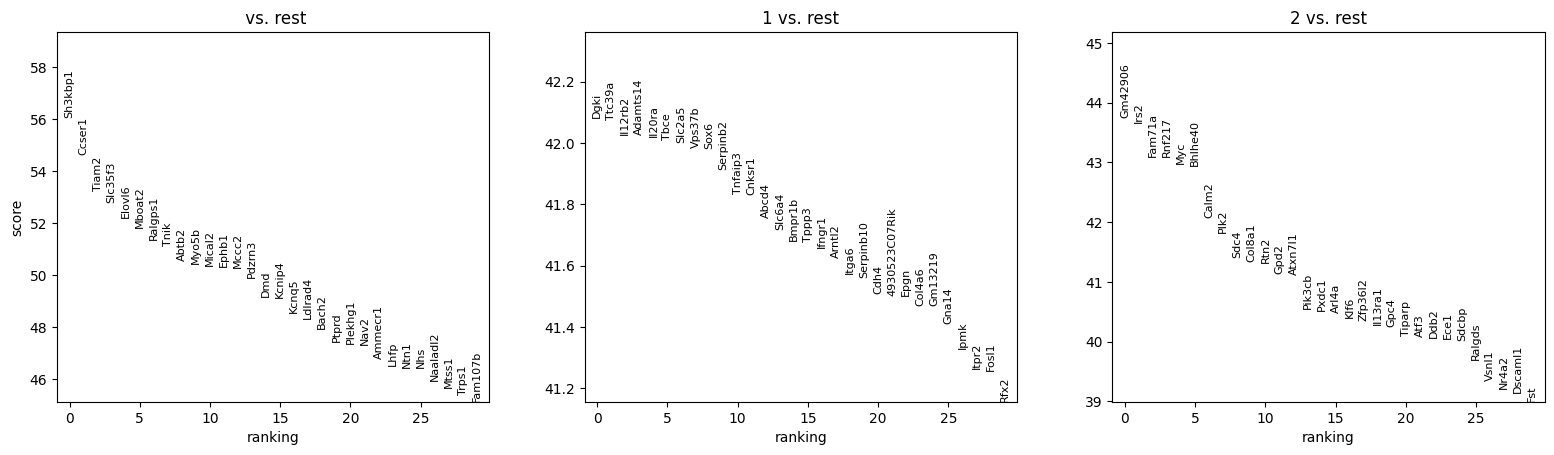

In [15]:
sc.tl.rank_genes_groups(A2R_predict, groupby='intergrate_leiden', method='wilcoxon')
sc.pl.rank_genes_groups(A2R_predict, n_genes=30, gene_symbols='name', sharey=False)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


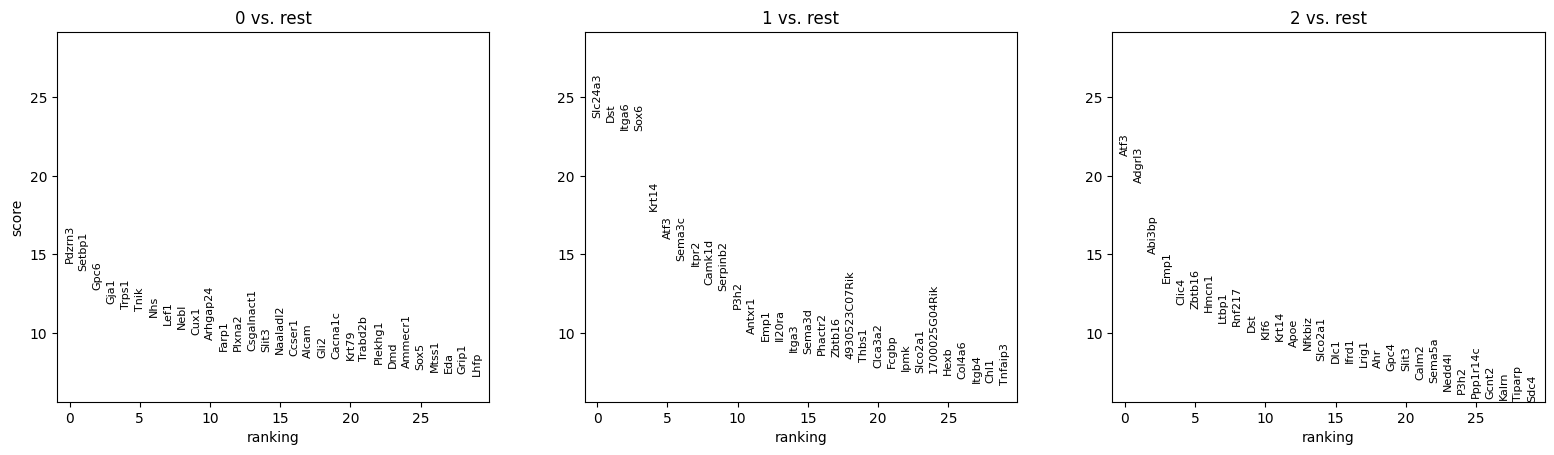

In [16]:
sc.tl.rank_genes_groups(R_origin_test, groupby='intergrate_leiden', method='wilcoxon')
sc.pl.rank_genes_groups(R_origin_test, n_genes=30, gene_symbols='name')

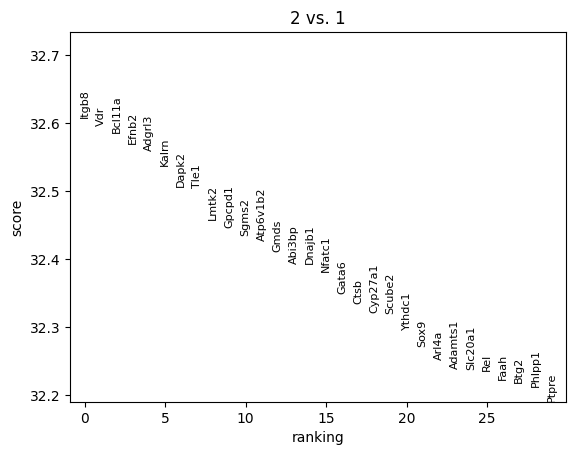

In [17]:
sc.tl.rank_genes_groups(A2R_predict, groupby='intergrate_leiden', method='wilcoxon', reference='1')
sc.pl.rank_genes_groups(A2R_predict, n_genes=30, gene_symbols='name', sharey=False, groups='2')

In [18]:
temp = list(A2R_predict.uns['rank_genes_groups']['names'])
group_list = [each[1] for each in temp]
i = 0
for each in group_list:
    if not each[0:2] == 'mt':
        print(each)
        i += 1
    if i == 30:
        break

Itgb8
Vdr
Bcl11a
Efnb2
Adgrl3
Kalrn
Dapk2
Tle1
Lmtk2
Gpcpd1
Sgms2
Atp6v1b2
Gmds
Abi3bp
Dnajb1
Nfatc1
Gata6
Ctsb
Cyp27a1
Scube2
Ythdc1
Sox9
Arl4a
Adamts1
Slc20a1
Rel
Faah
Btg2
Phlpp1
Ptpre


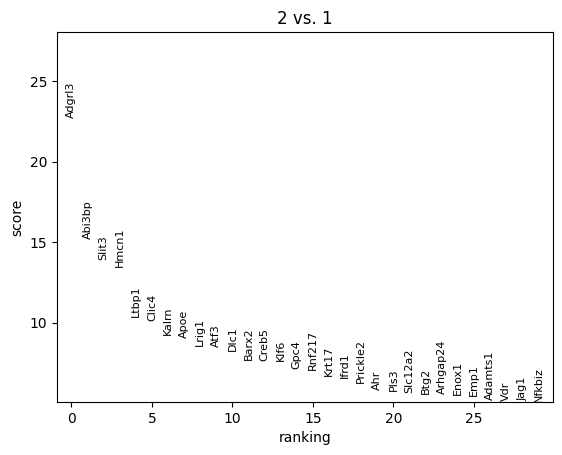

In [19]:
sc.tl.rank_genes_groups(R_origin_test, groupby='intergrate_leiden', method='wilcoxon', reference='1')
sc.pl.rank_genes_groups(R_origin_test, n_genes=30, gene_symbols='name', sharey=False, groups='2')

In [20]:
temp = list(R_origin_test.uns['rank_genes_groups']['names'])
group_list = [R_origin_test.var.name[each[1]] for each in temp]
for each in group_list[0:30]:
    print(each)

Adgrl3
Abi3bp
Slit3
Hmcn1
Ltbp1
Clic4
Kalrn
Apoe
Lrig1
Atf3
Dlc1
Barx2
Creb5
Klf6
Gpc4
Rnf217
Krt17
Ifrd1
Prickle2
Ahr
Pls3
Slc12a2
Btg2
Arhgap24
Enox1
Emp1
Adamts1
Vdr
Jag1
Nfkbiz
